# MNIST Digit Classification

In this tutorial, we'll go through the basics Convolutional Neural Networks (CNNs) using PyTorch and one of the most famous datasets in computer vision: MNIST.

MNIST is a collection of hand-drawn digits, a bit like the digital-age equivalent of learning to recognize handwritten numbers. By the end of this tutorial, you'll not only have a grasp of CNNs but also be able to build a model that can recognize these digits with remarkable accuracy.

## Imports

In [1]:
import torch
import matplotlib.pyplot as plt
import numpy as np
from torchvision import datasets as D, transforms as T
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import os
import os.path as P
import typing

## Variables and parameters

Here, we'll define some configurations a parementers to be used throughout the project.

In [2]:
# This sets the random seed to be using by random proceces.
# If you want trully random results, remove/comment this line.
torch.manual_seed(42)
# This one defines where the data will be downloaded to.
dataset_root = "data"
# This is the models checkpoints destination folder.
checkpoints_root = "checkpoints"
# This one is for the batchs size used by data loaders (don't worry, I'll explain).
batch_size = 64

# The MNIST Dataset

**MNIST** is a short for "Modified National Institute of Standards and Technology". It consists of 70,000 grayscale images, each measuring $28 \times 28$ pixels and representing a handwritten digit from 0 to 9, contributed by various individuals.

**MNIST** has been a cornerstone in the development of machine learning algorithms, serving as a benchmark for image classification and deep learning models. Yann LeCun, Léon Bottou, Yoshua Bengio and Patrick Affner used this dataset in their famous work ["Gradient-Based Learning Applied to Document Recognition"](http://vision.stanford.edu/cs598_spring07/papers/Lecun98.pdf), that laid the foundation for using deep learining techniques for image reconginition tasks and the effectiveness of Convolution Neural Networks in the 2010s.

## Download the Dataset and Creating the Data Loaders

Let's first begin by downloading the dataset. Given it's popularity, many deep learning frameworks already ship with tools to download it, and Pytorch is no exception.

In [3]:
transform = T.Compose((T.ToTensor(), T.Normalize(0.5, 0.5)))

train_set = D.MNIST(
    root=dataset_root,
    train=True,
    transform=transform,
    download=True
)

test_set = D.MNIST(
    root=dataset_root,
    train=False,
    transform=transform,
    download=True
)

First we define a **transform**, that converts each dataset's image into tensors (the fundamental data structure in Pytorch) and normalize the pixel values to make them suitable for training.

To download and loading the data itself, we use the **MNIST** function of [Pytorch's datasets package](https://pytorch.org/vision/main/datasets.html). We specify the location to store the date, the type of the dataset and transforms to be applyed to the images/labels. For the dataset type, we can specify **train=True** for the train set and **train=False** for the test set. The **download** parameters only indicates that we want to download the dataset, if necessary.

## Image samples

Let's visualize some images. The dataset itself will return a tuple which the first element is a tensor of dimensions $ \text{NUMBER OF CHANNELS} \times \text{NUMBER OF ROWS} \times \text{NUMBER OF COLUMNS} $. As all images are in grayscale, the actua dimensions are $ 1 \times 28 \times 28 $.

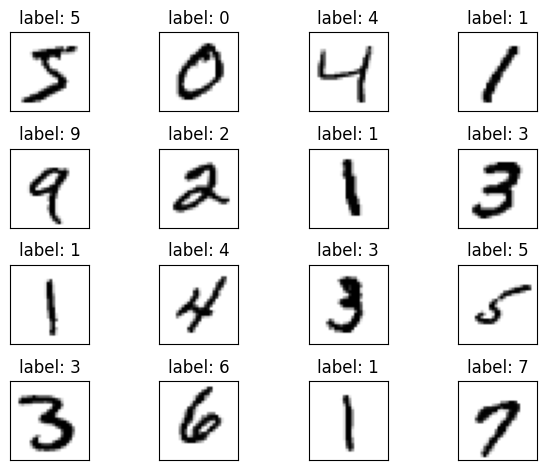

In [4]:
fig = plt.figure()
for i in range(16):
    img, lbl = train_set[i]
    img = img.numpy().squeeze()
    plt.subplot(4, 4, i+1)
    plt.imshow(img, cmap="gray_r")
    plt.title(f"label: {lbl}")
    plt.xticks([])
    plt.yticks([])
    
plt.tight_layout()
plt.show()

We can see that some of the digits more easily recongnizable than others.

## Create the Convolutional Neural Network

Our Convolutional Neural Network will be loosely based on the famous [LeNet](https://en.wikipedia.org/wiki/LeNet). There two main differences in relation to the original model:
- I replaced [Sigmod](https://machinelearningmastery.com/a-gentle-introduction-to-sigmoid-function/) for [ReLU](https://machinelearningmastery.com/rectified-linear-activation-function-for-deep-learning-neural-networks/) for activation function, as it [servs better for most applications](https://stats.stackexchange.com/a/126362).
- I also replace [Average Pooling layers for Max Pooling](https://machinelearningmastery.com/pooling-layers-for-convolutional-neural-networks/) layers, but feel free to test with another methods.

In [5]:
class Network(nn.Module):
    def __init__(self) -> None:
        super().__init__()
        self.conv1 = nn.Conv2d(1, 6, kernel_size=5)
        self.conv2 = nn.Conv2d(6, 16, kernel_size=5)
        self.fc1 = nn.Linear(256, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)
    
    def forward(self, X: torch.Tensor) -> torch.Tensor:
        X = F.relu(F.max_pool2d(self.conv1(X), 2))
        X = F.relu(F.max_pool2d(self.conv2(X), 2))
        X = X.view(-1, 256)
        X = F.relu(self.fc1(X))
        X = F.relu(self.fc2(X))
        X = self.fc3(X)
        return X

Where, I define our CNN model class, **Network**, which inherits from **nn.Module**. Inside our **Net** clçass, we define the layers of our neural network. I also define the **forward** method. This is where data flow through the layers and activations are applied.

We'll also initialize the network's weights using [Xavier initialization](https://cs230.stanford.edu/section/4/).

In [6]:
def init_weights(m: nn.Module) -> None:
    if isinstance(m, nn.Linear) or isinstance(m, nn.Conv2d):
        nn.init.xavier_uniform_(m.weight)

net = Network()
net.apply(init_weights)

Network(
  (conv1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=256, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

Next we'll detect if we can use CUDA to speed up training.

In [7]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [8]:
net.to(device)

Network(
  (conv1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=256, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

Last, we define the optimizer.

In [9]:
learning_rate = 0.01
momentum = 0.5

In [10]:
optimizer = optim.SGD(net.parameters(), lr=learning_rate, momentum=momentum)

 I'll use the **Stochastic Gradient Descent** (**SGD**), one of the most fundamental optimization algorithms. I also define the [**learning rate** and **momentum** parameters](https://machinelearningmastery.com/understand-the-dynamics-of-learning-rate-on-deep-learning-neural-networks/) to guide the training process effectively.

## Predictor Class

The original model class outputs raw logits for each class. Now we want real probabilities for each class.

In [11]:
class MNISTPredictor(nn.Module):
    def __init__(self, model: nn.Module, device: str) -> None:
        super().__init__()
        self.model = model
        self.device = device
    
    def forward(self, X: torch.Tensor) -> torch.Tensor:
        self.model.eval()
        with torch.no_grad():
            X = X.to(self.device)
            X = F.softmax(self.model(X), dim=1).detach()
        return X

## Train the model

We'll define two functions: one for the train step e one for the validation step.

In [12]:
def train_step(
    loader: DataLoader, net: nn.Module, optimizer: optim.Optimizer, device: str
) -> (int, int):
    net.train()
    
    train_loss = 0
    train_corrects = 0
    
    for data, target in iter(loader):
        data, target = data.to(device), target.to(device)
        
        optimizer.zero_grad()
        output = net(data)
        loss = F.cross_entropy(output, target)
        
        loss.backward()
        optimizer.step()
        
        with torch.no_grad():
            train_loss += loss.item()
            train_predictions = output.data.max(1, keepdim=True)[1]
            train_corrects += train_predictions.eq(target.data.view_as(train_predictions)).sum().item()
        
    return train_loss, train_corrects

In [13]:
def test_step(
    loader: DataLoader, net: nn.Module, device: str
) -> (int, int):
    net.eval()
    
    test_loss = 0
    test_corrects = 0
    
    with torch.no_grad():
        for data, target in iter(loader):
            data, target = data.to(device), target.to(device)
            
            output = net(data)
            
            loss = F.cross_entropy(output, target)
            
            test_loss += loss.item()
            test_predictions = output.data.max(1, keepdim=True)[1]
            test_corrects += test_predictions.eq(target.data.view_as(test_predictions)).sum().item()
    
    return test_loss, test_corrects

In [14]:
def save_checkpoint(
    net: nn.Module,
    optimizer: optim.Optimizer,
    test_loss: float,
    test_acc: float,
    epoch: int,
    model_filename: str
) -> None:
    state_dict = {
        "model": net.state_dict(),
        "optimizer": optimizer.state_dict(),
        "test_loss": test_loss,
        "test_acc": test_acc,
        "epoch": epoch
    }
    
    if not P.isdir(checkpoints_root):
        os.makedirs(checkpoints_root)
    
    ckpt_filepath = P.join(checkpoints_root, f"{model_filename}.pth")
    torch.save(state_dict, ckpt_filepath)

In [15]:
def load_checkpoint(model_filename: str) -> dict:
    ckpt_filepath = P.join(checkpoints_root, f"{model_filename}.pth")
    if not P.isfile(ckpt_filepath):
        raise RuntimeError(f"{ckpt_filepath} doesn't exists!")
    state_dict = torch.load(ckpt_filepath)
    return state_dict

In [16]:
def run_training(
    net: nn.Module,
    optimizer: optim.Optimizer,
    train_set: D.VisionDataset,
    test_set: D.VisionDataset,
    device: str,
    n_epochs: int,
    model_filename: typing.Optional[str] = None
) -> None:
    
    train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False)
    
    if model_filename:
        state_dict = load_checkpoint(model_filename)
        net.load_state_dict(state_dict["model"])
        optimizer.load_state_dict(state_dict["optimizer"])
        test_loss = state_dict["test_loss"]
        test_acc = state_dict["test_acc"]
        last_epoch = state_dict["epoch"]
    else:
        last_epoch = 0
    
    for epoch in range(last_epoch, n_epochs):
        train_loss, train_corrects = train_step(
            train_loader, net, optimizer, device
        )
        train_loss /= len(train_loader)
        train_acc = train_corrects / len(train_set)
        print(f"Train epoch {epoch} -- Loss: {train_loss:.4f} -- Acc: {train_acc:.4f} [{train_corrects}/{len(train_set)}]")
        
    test_loss, test_corrects = test_step(
        test_loader, net, device
    )
    test_loss /= len(test_loader)
    test_acc = test_corrects / len(test_set)
    print(f"Test -- Loss: {test_loss:.4f} -- Acc: {test_acc:.4f} [{test_corrects}/{len(test_set)}]")
    
    save_checkpoint(net, optimizer, test_loss, test_acc, epoch, "latest")

In [17]:
run_training(net, optimizer, train_set, test_set, device, 5)

Train epoch 0 -- Loss: 0.4138 -- Acc: 0.8759 [52554/60000]
Train epoch 1 -- Loss: 0.1066 -- Acc: 0.9663 [57975/60000]
Train epoch 2 -- Loss: 0.0790 -- Acc: 0.9749 [58495/60000]
Train epoch 3 -- Loss: 0.0646 -- Acc: 0.9805 [58830/60000]
Train epoch 4 -- Loss: 0.0543 -- Acc: 0.9830 [58978/60000]
Test -- Loss: 0.0497 -- Acc: 0.9831 [9831/10000]


## Model Evaluation

Now we'll plot some predictions.

In [18]:
def plot_pred(
    probabilities: np.ndarray,
    labels: np.ndarray,
    images: np.ndarray,
    sample_idx: int = 0,
    starting_idx: int = 0
):
    probs, lbl, img = probabilities[sample_idx], labels[sample_idx], images[sample_idx]
    prediction = np.argmax(probs)
    prediction_prob = np.max(probs)
    
    plt.imshow(img, cmap="gray_r")
    plt.xticks([])
    plt.yticks([])
    
    color = "green" if prediction == lbl else "red"
    
    plt.title(
        f"id: {starting_idx + sample_idx}\nprediction: {prediction} ({prediction_prob*100:2.0f}%) label: {lbl}",
        color=color
    )

In [19]:

def plot_pred_conf(
    probabilities: np.ndarray,
    labels: np.ndarray,
    sample_idx: int = 0
) -> None:
    probs, lbl = probabilities[sample_idx], labels[sample_idx]
    
    prediction = np.argmax(probs)
    
    plot = plt.bar([str(i) for i in range(10)], probs, color="gray")
    
    if prediction == lbl:
        plot[prediction].set_color("green")
    else:
        plot[prediction].set_color("red")
        plot[lbl].set_color("blue")

In [21]:
def display_samples(
    predictor: nn.Module,
    data_set: D.VisionDataset,
    samples_start_idx: int
) -> None:
    images, sample_labels = [], []
    for i in range(samples_start_idx, samples_start_idx + 12):
        img, lbl = data_set[i]
        images.append(img[None, :])
        sample_labels.append(lbl)
    
    images = torch.concat(images).to(device)

    sample_predictions = predictor(images).to("cpu").numpy()
    sample_images = images.permute(0, 2, 3, 1).to("cpu").numpy()
    
    n_rows = 4
    n_cols = 3
    n_images = n_cols * n_rows

    plt.figure(figsize=(7 * n_cols, 3 * n_rows))
    for i in range(n_images):
        plt.subplot(n_rows, 2 * n_cols, 2 * i + 1)
        plot_pred(sample_predictions, sample_labels, sample_images, i, samples_start_idx)
        plt.subplot(n_rows, 2 * n_cols, 2 * i + 2)
        plot_pred_conf(sample_predictions, sample_labels, i)

    plt.tight_layout()
    plt.show()

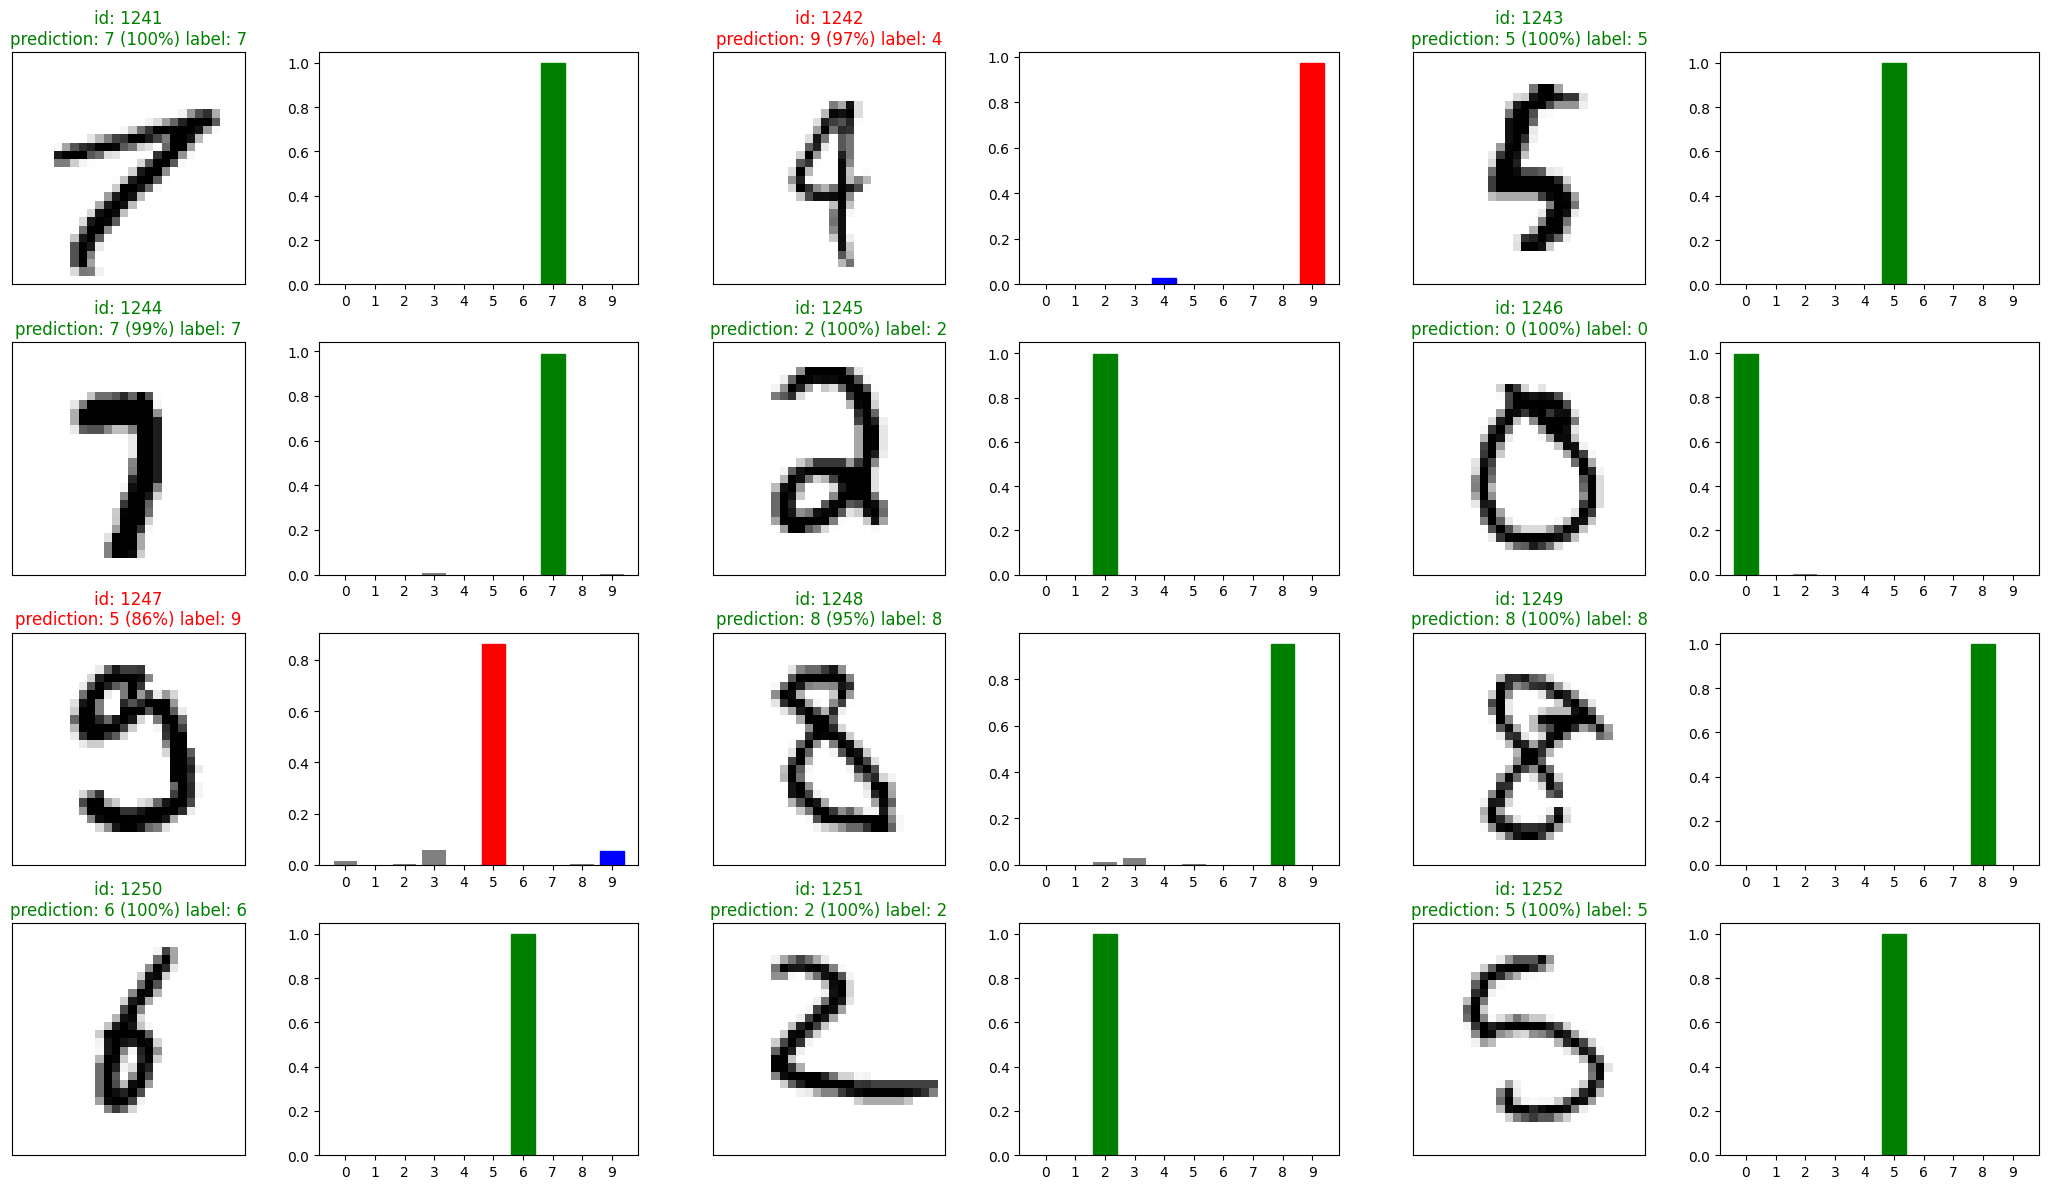

In [22]:
display_samples(MNISTPredictor(net, device), test_set, 1241)

## Resume training

In [23]:
resumed_model = Network().to(device)

learning_rate = 0.01
momentum = 0.5
resumed_optimizer = optim.SGD(resumed_model.parameters(), lr=learning_rate, momentum=momentum)

In [24]:
run_training(resumed_model, resumed_optimizer, train_set, test_set, device, 10, "latest")

Train epoch 4 -- Loss: 0.0477 -- Acc: 0.9851 [59106/60000]
Train epoch 5 -- Loss: 0.0422 -- Acc: 0.9869 [59214/60000]
Train epoch 6 -- Loss: 0.0381 -- Acc: 0.9880 [59278/60000]
Train epoch 7 -- Loss: 0.0337 -- Acc: 0.9895 [59369/60000]
Train epoch 8 -- Loss: 0.0314 -- Acc: 0.9901 [59409/60000]
Train epoch 9 -- Loss: 0.0285 -- Acc: 0.9912 [59473/60000]
Test -- Loss: 0.0345 -- Acc: 0.9890 [9890/10000]


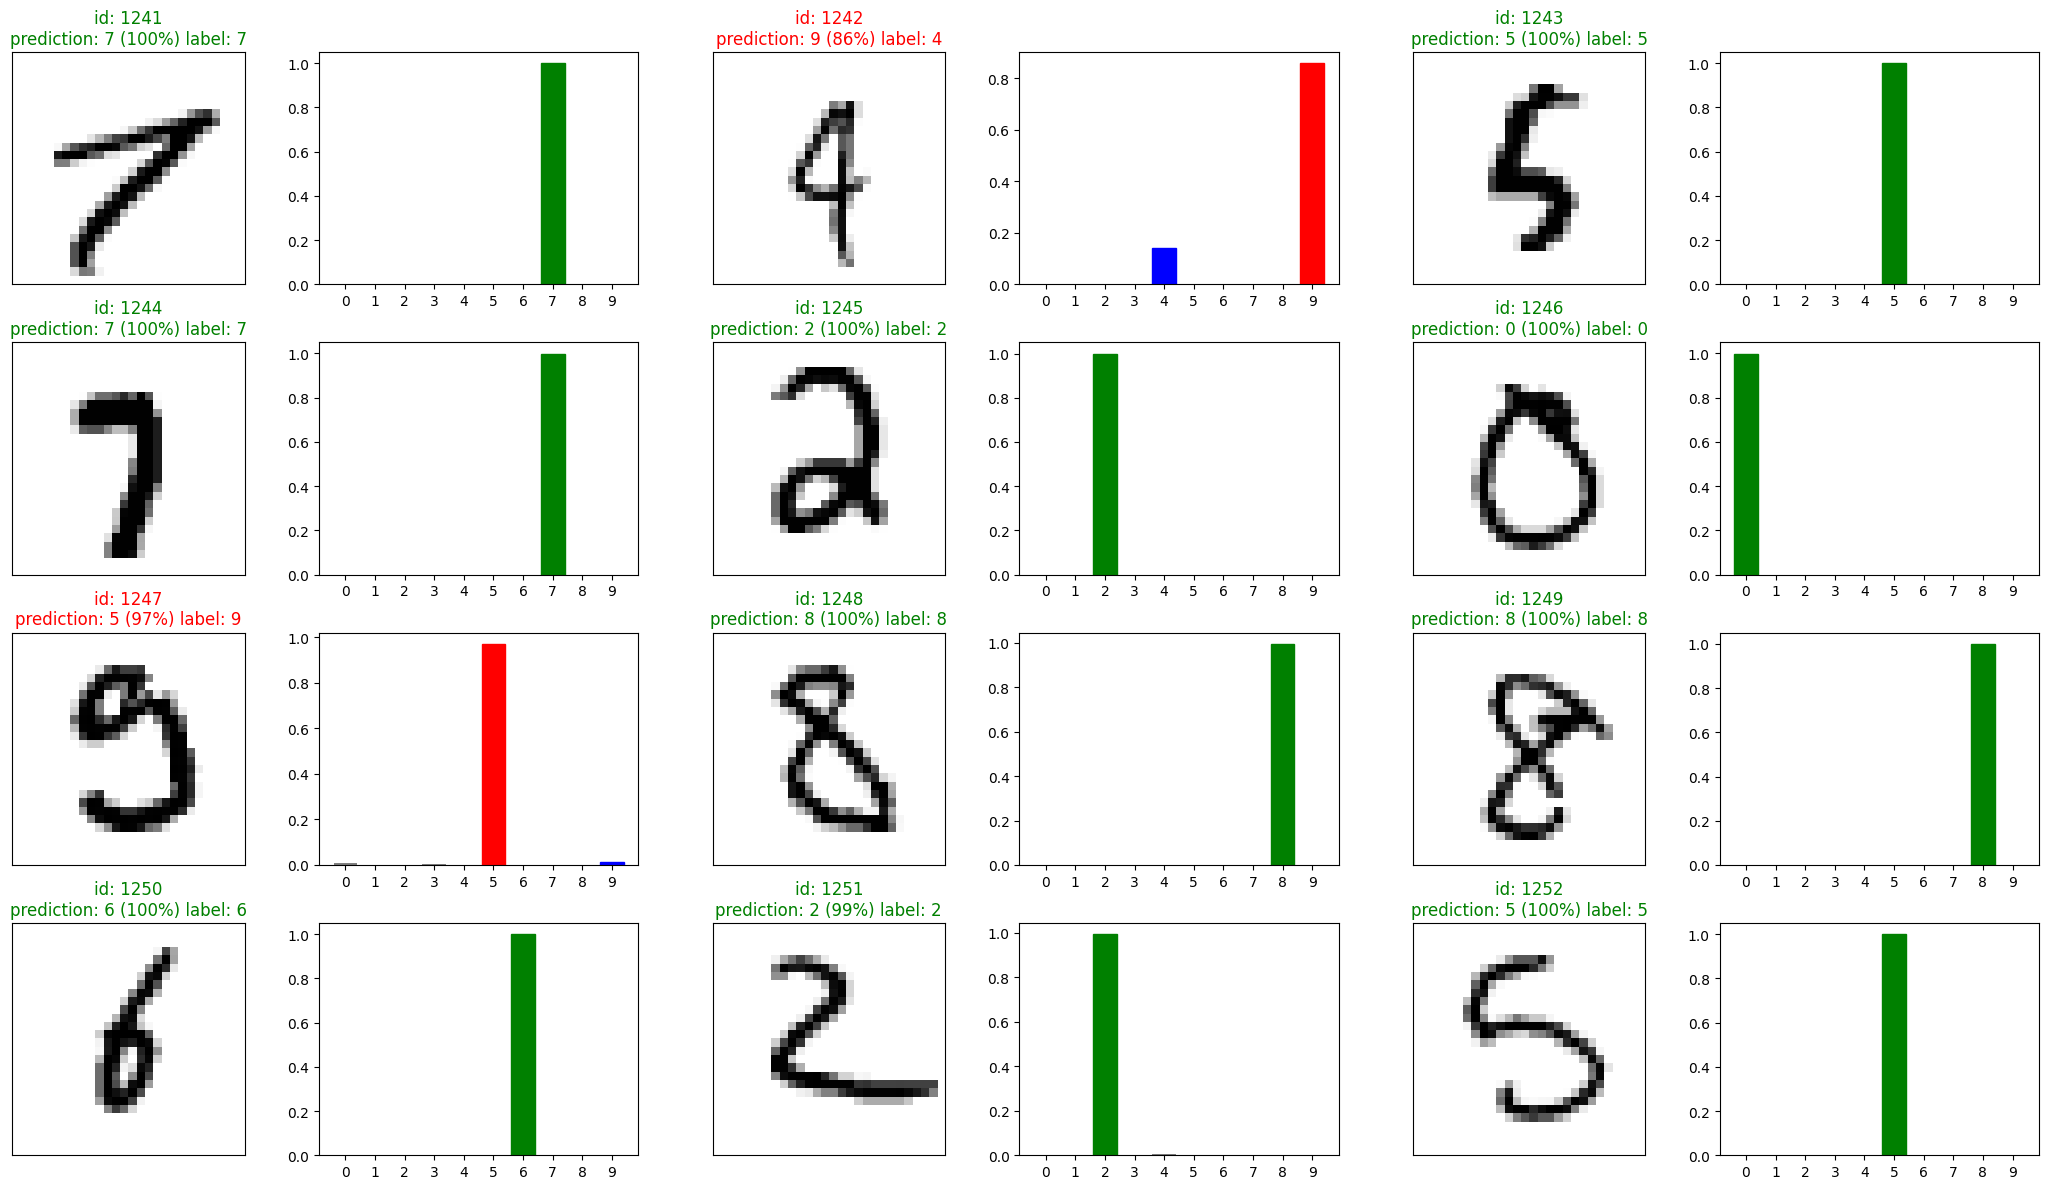

In [25]:
display_samples(MNISTPredictor(resumed_model, device), test_set, 1241)